# nnU-Net Segmentation

## Introduction
This notebook combines all the necessary steps for preparing data for nnU-Net, including fetching and splitting the original data, downsampling images and labels, remapping label values, and creating the `dataset.json` file.

## Imports and Setup

In [1]:
import os
import random
import json
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk

from medpy.metric.binary import dc
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Define variables for dataset types
ascending = "Ascending"
sinuses = "Sinuses"
root_top = "RootTop"

## Downsampling
### Resample Images and Labels

In [2]:
# Define target spacing
TARGET_SPACING = (2.0, 2.0, 2.0)

# Define directories
IMAGES_DIR = "../../Data/images"
LABELS_DIR = "../../Data/labels"
OUTPUT_IMAGES_DIR = "../Resampled/Common_2mm_images"

def resample_image(image_path, output_path, is_label=False):
    if os.path.exists(output_path):
        print(f"Skipping {output_path}, already exists.")
        return
    
    image = sitk.ReadImage(image_path)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / TARGET_SPACING[i])))
        for i in range(3)
    ]
    
    interpolator = sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear

    resampled_image = sitk.Resample(
        image,
        new_size,
        sitk.Transform(),
        interpolator,
        image.GetOrigin(),
        TARGET_SPACING,
        image.GetDirection(),
        0,
        image.GetPixelID()
    )
    
    sitk.WriteImage(resampled_image, output_path)
    print(f"Resampled {output_path} successfully with consistent coordinates.")

def downsample_images():
    os.makedirs(OUTPUT_IMAGES_DIR, exist_ok=True)
    processed_count = 0
    
    with ThreadPoolExecutor() as executor:
        futures = []
        image_files = [f for f in sorted(os.listdir(IMAGES_DIR)) if f.endswith(".nii.gz")]
        for image_file in tqdm(image_files, desc="Resampling images"):
            image_path = os.path.join(IMAGES_DIR, image_file)
            output_image_path = os.path.join(OUTPUT_IMAGES_DIR, image_file)
            futures.append(executor.submit(resample_image, image_path, output_image_path, False))
        
        for future in tqdm(futures, desc="Processing futures"):
            try:
                future.result()
                processed_count += 1
            except Exception as e:
                print(f"Error processing image: {e}")
                
    print(f"Resampling Finished! {processed_count} images are saved in {OUTPUT_IMAGES_DIR}")

def downsample_labels(dataset_type):
    output_labels_dir = f"../Resampled/{dataset_type}_2mm_labels"
    
    os.makedirs(output_labels_dir, exist_ok=True)
    processed_count = 0
    
    with ThreadPoolExecutor() as executor:
        futures = []
        label_files = [f for f in sorted(os.listdir(LABELS_DIR)) if f.endswith(f"_{dataset_type}.nii.gz")]
        for label_file in tqdm(label_files, desc=f"Resampling labels for {dataset_type}"):
            label_path = os.path.join(LABELS_DIR, label_file)
            output_label_path = os.path.join(output_labels_dir, label_file)
            futures.append(executor.submit(resample_image, label_path, output_label_path, True))
        
        for future in tqdm(futures, desc="Processing futures"):
            try:
                future.result()
                processed_count += 1
            except Exception as e:
                print(f"Error processing label: {e}")

    print(f"Resampling Finished! {processed_count} labels are saved in {output_labels_dir}")

# Downsample images once
downsample_images()

# Downsample labels for Ascending dataset
downsample_labels(ascending)

# Downsample labels for Sinuses dataset
downsample_labels(sinuses)

# Downsample labels for RootTop dataset
downsample_labels(root_top)

Resampling images: 100%|██████████| 215/215 [00:00<00:00, 10547.94it/s]


Skipping ../Resampled/Common_2mm_images/001_20240805_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/002_20240805_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/004_20240805_12.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/006_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/005_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/007_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/008_20240909_13.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/009_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/012_20240909_12.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/010_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/015_20240909_10.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/011_20240909_3.nii.gz, already exists.
Skipping ../Resampled/Common_2mm_images/0

Processing futures: 100%|██████████| 215/215 [00:00<00:00, 438393.47it/s]


Resampling Finished! 215 images are saved in ../Resampled/Common_2mm_images


Resampling labels for Ascending: 100%|██████████| 215/215 [00:00<00:00, 13051.24it/s]


Skipping ../Resampled/Ascending_2mm_labels/001_20240805_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/002_20240805_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/004_20240805_12_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/005_20240909_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/007_20240909_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/008_20240909_13_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/006_20240909_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/011_20240909_3_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/009_20240909_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/010_20240909_10_Ascending.nii.gz, already exists.
Skipping ../Resampled/Ascending_2mm_labels/012_20240909_12_Ascending.ni

Processing futures: 100%|██████████| 215/215 [00:00<00:00, 402938.05it/s]


Resampling Finished! 215 labels are saved in ../Resampled/Ascending_2mm_labels


Resampling labels for Sinuses: 100%|██████████| 215/215 [00:00<00:00, 13605.54it/s]


Skipping ../Resampled/Sinuses_2mm_labels/001_20240805_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/002_20240805_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/004_20240805_12_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/005_20240909_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/008_20240909_13_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/007_20240909_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/006_20240909_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/009_20240909_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/010_20240909_10_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/011_20240909_3_Sinuses.nii.gz, already exists.
Skipping ../Resampled/Sinuses_2mm_labels/012_20240909_12_Sinuses.nii.gz, already exists.
Skipping ../Resampled/

Processing futures: 100%|██████████| 215/215 [00:00<00:00, 425165.19it/s]


Resampling Finished! 215 labels are saved in ../Resampled/Sinuses_2mm_labels


Resampling labels for RootTop: 100%|██████████| 215/215 [00:00<00:00, 14767.47it/s]


Skipping ../Resampled/RootTop_2mm_labels/001_20240805_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/002_20240805_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/004_20240805_12_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/005_20240909_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/007_20240909_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/006_20240909_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/008_20240909_13_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/009_20240909_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/011_20240909_3_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/010_20240909_10_RootTop.nii.gz, already exists.
Skipping ../Resampled/RootTop_2mm_labels/012_20240909_12_RootTop.nii.gz, already exists.
Skipping ../Resampled/

Processing futures: 100%|██████████| 215/215 [00:00<00:00, 397959.12it/s]

Resampling Finished! 215 labels are saved in ../Resampled/RootTop_2mm_labels


## Data Preparation
### Fetch and Split Downsampled Data

In [3]:
def setup_directories(dataset_type):
    
    images_dir = "../Resampled/Common_2mm_images"
    labels_dir = f"../Resampled/{dataset_type}_2mm_labels"

    print(f"dataset_type: {dataset_type}")  # Debugging print statement

    if dataset_type == ascending:
        dataset_number = "001"
    elif dataset_type == sinuses:
        dataset_number = "002"
    elif dataset_type == root_top:
        dataset_number = "003"
    else:
        dataset_number = "000"  # Default or other types
    
    output_dir = f"../nnUNet_raw/Dataset{dataset_number}_{dataset_type}"
    print(f"output_dir: {output_dir}")  # Debugging print statement

    images_train_dir = os.path.join(output_dir, "imagesTr")
    images_test_dir = os.path.join(output_dir, "imagesTs")
    labels_train_dir = os.path.join(output_dir, "labelsTr")
    labels_test_dir = os.path.join(output_dir, "labelsTs")
    train_test_record_file = os.path.join(output_dir, "train_test_split.json")

    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_test_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_test_dir, exist_ok=True)

    return images_dir, labels_dir, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, train_test_record_file

In [4]:
def prepare_data(dataset_type):
    images_dir, labels_dir, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, train_test_record_file = setup_directories(dataset_type)
    
    all_images = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])

    random.seed(91)
    random.shuffle(all_images)

    dataset_usage_ratio = 0.2  
    train_test_ratio = 0.8     

    subset_count = int(len(all_images) * dataset_usage_ratio)
    subset_images = all_images[:subset_count]

    train_count = int(len(subset_images) * train_test_ratio)

    train_files = subset_images[:train_count]
    test_files = subset_images[train_count:]

    train_test_record = {
        "dataset_usage_ratio": dataset_usage_ratio,
        "train_test_ratio": train_test_ratio,
        "train_count": len(train_files),
        "test_count": len(test_files),
        "train": [],
        "test": [],
        "filename_mapping": {}  
    }

    for idx, image_filename in enumerate(tqdm(train_files, desc="Copying training files")):
        image_path = os.path.join(images_dir, image_filename)
        new_filename = f"{dataset_type}_{idx:05d}_0000.nii.gz"
        train_test_record["train"].append(new_filename)
        train_test_record["filename_mapping"][new_filename] = image_filename
        shutil.copy(image_path, os.path.join(images_train_dir, new_filename))

        label_filename = image_filename.replace(".nii.gz", f"_{dataset_type}.nii.gz")
        label_path = os.path.join(labels_dir, label_filename)

        if os.path.exists(label_path):
            new_label_filename = f"{dataset_type}_{idx:05d}.nii.gz"
            shutil.copy(label_path, os.path.join(labels_train_dir, new_label_filename))
            train_test_record["filename_mapping"][new_label_filename] = label_filename

    for idx, image_filename in enumerate(tqdm(test_files, desc="Copying testing files")):
        image_path = os.path.join(images_dir, image_filename)
        new_filename = f"{dataset_type}_{idx+train_count:05d}_0000.nii.gz"
        train_test_record["test"].append(new_filename)
        train_test_record["filename_mapping"][new_filename] = image_filename
        shutil.copy(image_path, os.path.join(images_test_dir, new_filename))

        label_filename = image_filename.replace(".nii.gz", f"_{dataset_type}.nii.gz")
        label_path = os.path.join(labels_dir, label_filename)

        if os.path.exists(label_path):
            new_label_filename = f"{dataset_type}_{idx+train_count:05d}.nii.gz"
            shutil.copy(label_path, os.path.join(labels_test_dir, new_label_filename))
            train_test_record["filename_mapping"][new_label_filename] = label_filename

    with open(train_test_record_file, "w") as f:
        json.dump(train_test_record, f, indent=4)

    print(f"Data split! Using {dataset_usage_ratio * 100}% of the original dataset")
    print(f"Training set: {len(train_files)} images and {len(os.listdir(labels_train_dir))} labels")
    print(f"Testing set: {len(test_files)} images and {len(os.listdir(labels_test_dir))} labels")
    print(f"Data report is saved at {train_test_record_file}")

# Prepare data for Ascending dataset
prepare_data(ascending)

# Prepare data for Sinuses dataset
prepare_data(sinuses)

# Prepare data for RootTop dataset
prepare_data(root_top)

dataset_type: Ascending
output_dir: ../nnUNet_raw/Dataset001_Ascending


Copying testing files: 100%|██████████| 9/9 [00:00<00:00, 29.76it/s]


Data split! Using 20.0% of the original dataset
Training set: 34 images and 34 labels
Testing set: 9 images and 9 labels
Data report is saved at ../nnUNet_raw/Dataset001_Ascending/train_test_split.json
dataset_type: Sinuses
output_dir: ../nnUNet_raw/Dataset002_Sinuses


Copying testing files: 100%|██████████| 9/9 [00:00<00:00, 30.54it/s]


Data split! Using 20.0% of the original dataset
Training set: 34 images and 34 labels
Testing set: 9 images and 9 labels
Data report is saved at ../nnUNet_raw/Dataset002_Sinuses/train_test_split.json
dataset_type: RootTop
output_dir: ../nnUNet_raw/Dataset003_RootTop


Copying testing files: 100%|██████████| 9/9 [00:00<00:00, 42.55it/s]

Data split! Using 20.0% of the original dataset
Training set: 34 images and 34 labels
Testing set: 9 images and 9 labels
Data report is saved at ../nnUNet_raw/Dataset003_RootTop/train_test_split.json


## Label Remapping
### Remap Label Values

In [5]:
def remap_labels(label_path, dataset_type):
    # print(f"Processing {label_path}...")
    
    image = sitk.ReadImage(label_path)
    array = sitk.GetArrayFromImage(image)

    if dataset_type == ascending:
        array[array == 4] = 1
    elif dataset_type == sinuses:
        array[(array == 1) | (array == 2) | (array == 3)] = array[(array == 1) | (array == 2) | (array == 3)]
    elif dataset_type == root_top:
        array[array == 5] = 1

    new_image = sitk.GetImageFromArray(array)
    new_image.SetSpacing(image.GetSpacing())
    new_image.SetOrigin(image.GetOrigin())
    new_image.SetDirection(image.GetDirection())

    sitk.WriteImage(new_image, label_path)
    # print(f"Updated {label_path}")

def process_labels(dataset_type):
    _, _, _, _, labels_train_dir, labels_test_dir, _ = setup_directories(dataset_type)
    
    for filename in tqdm(os.listdir(labels_train_dir), desc=f"Remapping training labels for {dataset_type}"):
        if filename.endswith(".nii.gz"):
            remap_labels(os.path.join(labels_train_dir, filename), dataset_type)
    
    for filename in tqdm(os.listdir(labels_test_dir), desc=f"Remapping testing labels for {dataset_type}"):
        if filename.endswith(".nii.gz"):
            remap_labels(os.path.join(labels_test_dir, filename), dataset_type)
    
    print(f"All the labels for {dataset_type} are remapped.")

# Process labels for Ascending dataset
process_labels(ascending)

# Process labels for Sinuses dataset
process_labels(sinuses)

# Process labels for RootTop dataset
process_labels(root_top)

dataset_type: Ascending
output_dir: ../nnUNet_raw/Dataset001_Ascending


Remapping testing labels for Ascending: 100%|██████████| 9/9 [00:00<00:00, 87.56it/s]


All the labels for Ascending are remapped.
dataset_type: Sinuses
output_dir: ../nnUNet_raw/Dataset002_Sinuses


Remapping testing labels for Sinuses: 100%|██████████| 9/9 [00:00<00:00, 58.37it/s]


All the labels for Sinuses are remapped.
dataset_type: RootTop
output_dir: ../nnUNet_raw/Dataset003_RootTop


Remapping testing labels for RootTop: 100%|██████████| 9/9 [00:00<00:00, 80.30it/s]

All the labels for RootTop are remapped.


## Check Direction Consistency

In [6]:
def get_file_paths(images_dir, labels_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('_0000.nii.gz')]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.nii.gz')]
    return image_files, label_files

def check_origins(images_dir, labels_dir, image_files, label_files):
    all_consistent = True

    for image_file in tqdm(image_files, desc="Checking origins"):
        base_name = image_file.replace('_0000.nii.gz', '')
        label_file = f"{base_name}.nii.gz"

        if label_file in label_files:
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, label_file)

            image = sitk.ReadImage(image_path)
            label = sitk.ReadImage(label_path)

            image_origin = image.GetOrigin()
            label_origin = label.GetOrigin()

            if image_origin != label_origin:
                print(f"Origins are inconsistent for {base_name}.\nImage origin: {image_origin}\nSegmentation origin: {label_origin}")
                all_consistent = False
        else:
            print(f"Segmentation file not found for {base_name}.")
            all_consistent = False

    return all_consistent

# Define base path
base_path = "../nnUNet_raw/"

# Define datasets
datasets = {
    "Dataset001_Ascending": {
        "images_dir": os.path.join(base_path, "Dataset001_Ascending/imagesTr"),
        "labels_dir": os.path.join(base_path, "Dataset001_Ascending/labelsTr")
    },
    "Dataset002_Sinuses": {
        "images_dir": os.path.join(base_path, "Dataset002_Sinuses/imagesTr"),
        "labels_dir": os.path.join(base_path, "Dataset002_Sinuses/labelsTr")
    },
    "Dataset003_RootTop": {
        "images_dir": os.path.join(base_path, "Dataset003_RootTop/imagesTr"),
        "labels_dir": os.path.join(base_path, "Dataset003_RootTop/labelsTr")
    }
}

# Iterate through datasets and check origins
for dataset_name, paths in datasets.items():
    print(f"Checking origins for {dataset_name}...")
    
    # Get file paths
    image_files, label_files = get_file_paths(paths["images_dir"], paths["labels_dir"])

    # Check origins
    all_consistent = check_origins(paths["images_dir"], paths["labels_dir"], image_files, label_files)

    if all_consistent:
        print(f"All origins are consistent for {dataset_name}.")

Checking origins for Dataset001_Ascending...


Checking origins: 100%|██████████| 34/34 [00:01<00:00, 17.62it/s]


All origins are consistent for Dataset001_Ascending.
Checking origins for Dataset002_Sinuses...


Checking origins: 100%|██████████| 34/34 [00:01<00:00, 19.19it/s]


All origins are consistent for Dataset002_Sinuses.
Checking origins for Dataset003_RootTop...


Checking origins: 100%|██████████| 34/34 [00:01<00:00, 19.09it/s]

All origins are consistent for Dataset003_RootTop.


## Dataset JSON Creation
### Create dataset.json

In [7]:
def create_dataset_json(dataset_type):
    _, _, images_train_dir, images_test_dir, labels_train_dir, labels_test_dir, _ = setup_directories(dataset_type)

    train_cases = sorted([f.replace(".nii.gz", "") for f in os.listdir(images_train_dir) if f.endswith(".nii.gz")])
    test_cases = sorted([f.replace(".nii.gz", "") for f in os.listdir(images_test_dir) if f.endswith(".nii.gz")])

    if dataset_type == ascending:
        labels_dict = {
            "background": 0,
            "ascending_aorta": 1
        }
    elif dataset_type == sinuses:
        labels_dict = {
            "background": 0,
            "root_1": 1,
            "root_2": 2,
            "root_3": 3
        }
    elif dataset_type == root_top:
         labels_dict = {
            "background": 0,
            "root_top": 1
        }       
    dataset_info = {
        "channel_names": {"0": "CT"},  
        "labels": labels_dict,
        "numTraining": len(train_cases),
        "file_ending": ".nii.gz",      
        "training": [{"image": f"./imagesTr/{case}.nii.gz", "label": f"./labelsTr/{case}.nii.gz"} for case in train_cases],
        "test": [{"image": f"./imagesTs/{case}.nii.gz", "label": f"./labelsTs/{case}.nii.gz"} for case in test_cases]
    }

    dataset_dir = os.path.dirname(images_train_dir)
    json_path = os.path.join(dataset_dir, "dataset.json")
    with open(json_path, "w") as json_file:
        json.dump(dataset_info, json_file, indent=4)
    
    print(f"Dataset JSON created at {json_path}")

# Create dataset JSON for Ascending dataset
create_dataset_json(ascending)

# Create dataset JSON for Sinuses dataset
create_dataset_json(sinuses)

# Create dataset JSON for RootTop dataset
create_dataset_json(root_top)

dataset_type: Ascending
output_dir: ../nnUNet_raw/Dataset001_Ascending
Dataset JSON created at ../nnUNet_raw/Dataset001_Ascending/dataset.json
dataset_type: Sinuses
output_dir: ../nnUNet_raw/Dataset002_Sinuses
Dataset JSON created at ../nnUNet_raw/Dataset002_Sinuses/dataset.json
dataset_type: RootTop
output_dir: ../nnUNet_raw/Dataset003_RootTop
Dataset JSON created at ../nnUNet_raw/Dataset003_RootTop/dataset.json


## Function: plot_random_image_and_label

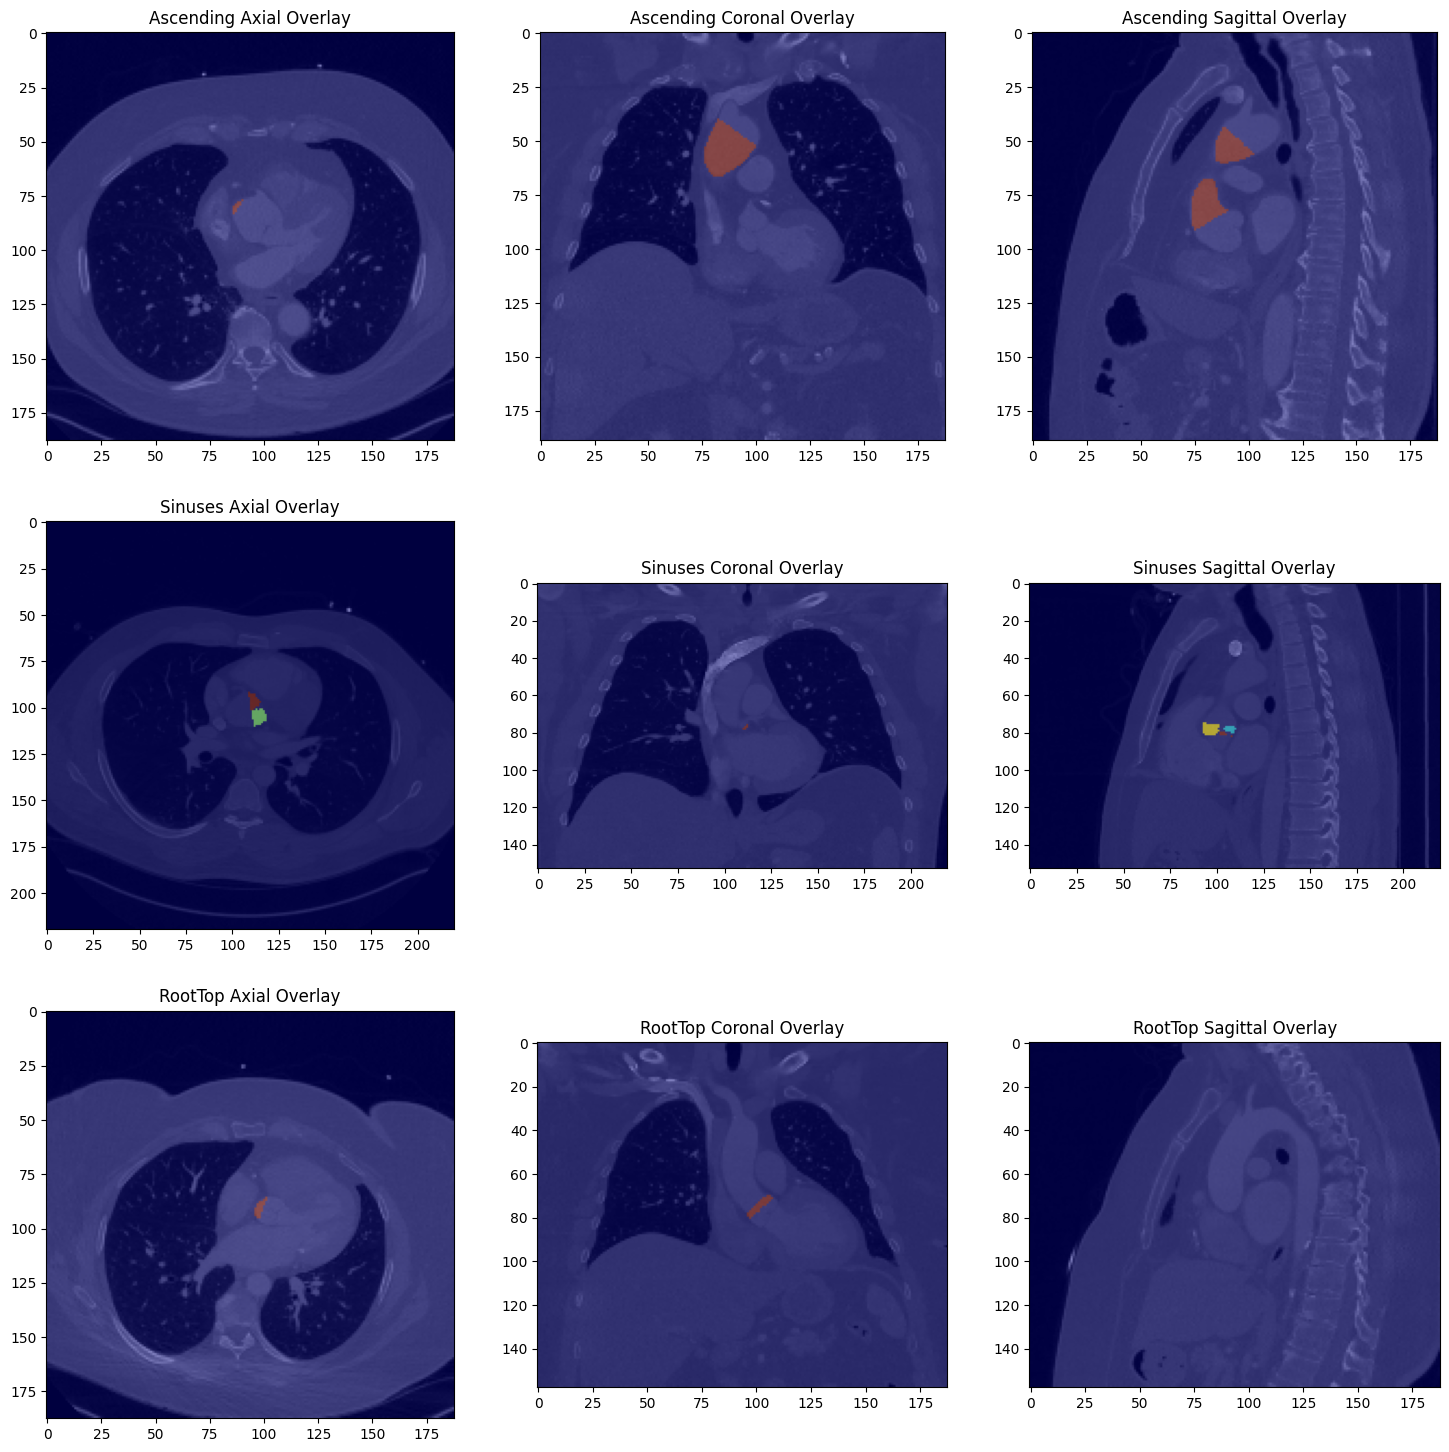

In [8]:
def plot_random_overlay(dataset_type):
    # Define the directories for resampled images and labels
    images_dir = "../Resampled/Common_2mm_images"
    labels_dir = f"../Resampled/{dataset_type}_2mm_labels"

    # Get a list of all image files in the images directory
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".nii.gz")]

    # Randomly select one image file
    random_image_file = random.choice(image_files)

    # Construct the corresponding label file path
    label_file = random_image_file.replace(".nii.gz", f"_{dataset_type}.nii.gz")

    # Read the image and label using SimpleITK
    image_path = os.path.join(images_dir, random_image_file)
    label_path = os.path.join(labels_dir, label_file)

    image = sitk.ReadImage(image_path)
    label = sitk.ReadImage(label_path)

    # Ensure the origin, spacing, and direction are consistent
    label.SetOrigin(image.GetOrigin())
    label.SetSpacing(image.GetSpacing())
    label.SetDirection(image.GetDirection())

    # Convert the images to numpy arrays for plotting
    image_array = sitk.GetArrayFromImage(image)
    label_array = sitk.GetArrayFromImage(label)

    # Flip the images vertically if they appear upside down
    image_array = np.flipud(image_array)
    label_array = np.flipud(label_array)

    # Get the middle slices for overlay in axial, coronal, and sagittal planes
    middle_axial = image_array.shape[0] // 2
    middle_coronal = image_array.shape[1] // 2
    middle_sagittal = image_array.shape[2] // 2

    return (image_array[middle_axial, :, :], label_array[middle_axial, :, :]), \
           (image_array[:, middle_coronal, :], label_array[:, middle_coronal, :]), \
           (image_array[:, :, middle_sagittal], label_array[:, :, middle_sagittal])

# Plot overlays for Ascending, Sinuses, and RootTop datasets in three rows
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

datasets = [ascending, sinuses, root_top]
planes = ['Axial', 'Coronal', 'Sagittal']

for i, dataset in enumerate(datasets):
    axial_slices, coronal_slices, sagittal_slices = plot_random_overlay(dataset)
    
    for j, (image_slice, label_slice) in enumerate([axial_slices, coronal_slices, sagittal_slices]):
        axes[i, j].imshow(image_slice, cmap="gray")
        axes[i, j].imshow(label_slice, cmap="jet", alpha=0.5)
        axes[i, j].set_title(f"{dataset} {planes[j]} Overlay")

plt.show()

## Next Steps

In this notebook, we have successfully prepared the data for nnU-Net by performing the following steps:
- Resampling images and labels to a consistent spacing.
- Setting up directories for training and testing datasets.
- Remapping label values for compatibility with nnU-Net.

Next, follow these steps to proceed:

1. **Plan and Preprocess the Dataset**:

    Use the following command to plan and preprocess the dataset:

    ```bash
    nnUNetv2_plan_and_preprocess -d DATASET -pl nnUNetPlannerResEnc(M/L/XL)
    ```

    Example for dataset `001`:

    ```bash
    nnUNetv2_plan_and_preprocess -d 001
    ```

2. **Train the Model**:

    Train the nnU-Net model using the following command:

    ```bash
    nnUNetv2_train DATASET_NAME_OR_ID UNET_CONFIGURATION FOLD
    ```

    Example for training all folds of dataset `001` with `3d_fullres` configuration:

    ```bash
    nnUNetv2_train 001 3d_fullres 0 --npz
    ```

3. **Run Predictions**:

    Use the following command to generate predictions:

    ```bash
    nnUNetv2_predict -i INPUT_DIR -o OUTPUT_DIR -d DATASET -c CONFIGURATION -f FOLD --save_probabilities
    ```

    Example for predicting dataset `001`:

    ```bash
    nnUNetv2_predict -i nnUNet_raw/Dataset001_Ascending/imagesTs -o nnUNet_raw/outputs/Ascending_predictions_fold0 -d 001 -c 3d_fullres -f 0 --save_probabilities
    ```
    
    Example for ensembling multiple configurations:

    ```bash
    nnUNetv2_ensemble -i nnUNet_raw/Outputs/Ascending_predictions_fold0 nnUNet_raw/Outputs/Ascending_predictions_fold1 nnUNet_raw/Outputs/Ascending_predictions_fold2 nnUNet_raw/Outputs/Ascending_predictions_fold3 nnUNet_raw/Outputs/Ascending_predictions_fold4 -o nnUNet_raw/Outputs/Ascending_Ensemble_Outputs -np 4
    ```


## Evaluation
### Calculate Dice scores and pixel-wise differences

In [16]:
# Dataset configuration
DATASETS = {
    "1": {
        "name": "Ascending",
        "pred_dir": "../nnUNet_raw/Outputs/Ascending_Ensemble_Outputs",
        "gt_dir": "../nnUNet_raw/Dataset001_Ascending/labelsTs"
    },
    "2": {
        "name": "Sinuses",
        "pred_dir": "../nnUNet_raw/Outputs/Sinuses_Ensemble_Outputs",
        "gt_dir": "../nnUNet_raw/Dataset002_Sinuses/labelsTs"
    },
    "3": {
        "name": "RootTop",
        "pred_dir": "../nnUNet_raw/Outputs/RootTop_Ensemble_Outputs",
        "gt_dir": "../nnUNet_raw/Dataset003_RootTop/labelsTs"
    }
}

def select_dataset():
    """Interactive dataset selection"""
    print("Available datasets:")
    for key, dataset in DATASETS.items():
        print(f"{key}: {dataset['name']}")
    
    while True:
        choice = input("Select dataset (1-3): ")
        if choice in DATASETS:
            return DATASETS[choice]
        print("Invalid selection. Please try again.")

def evaluate_predictions(dataset):
    """Main evaluation function"""
    # Validate directories
    if not os.path.exists(dataset['pred_dir']):
        raise FileNotFoundError(f"Prediction directory not found: {dataset['pred_dir']}")
    if not os.path.exists(dataset['gt_dir']):
        raise FileNotFoundError(f"Ground truth directory not found: {dataset['gt_dir']}")

    results = []
    pred_files = sorted([f for f in os.listdir(dataset['pred_dir']) if f.endswith(".nii.gz")])
    
    for pred_filename in tqdm(pred_files, desc=f"Evaluating {dataset['name']}"):
        pred_path = os.path.join(dataset['pred_dir'], pred_filename)
        
        # Flexible filename matching
        gt_candidates = [
            pred_filename,
            pred_filename.replace("_0000.nii.gz", ".nii.gz"),
            pred_filename.split("_")[0] + ".nii.gz"  # For case_0000.nii.gz → case.nii.gz
        ]
        
        gt_path = None
        for candidate in gt_candidates:
            candidate_path = os.path.join(dataset['gt_dir'], candidate)
            if os.path.exists(candidate_path):
                gt_path = candidate_path
                break
        
        if not gt_path:
            print(f"⚠ Warning: Ground truth for {pred_filename} not found. Skipping.")
            continue

        try:
            # Load and validate images
            pred_img = sitk.ReadImage(pred_path)
            gt_img = sitk.ReadImage(gt_path)
            
            pred_array = sitk.GetArrayFromImage(pred_img)
            gt_array = sitk.GetArrayFromImage(gt_img)
            
            if pred_array.shape != gt_array.shape:
                print(f"⚠ Shape mismatch for {pred_filename}: "
                      f"Pred {pred_array.shape} vs GT {gt_array.shape}")
                continue
            
            # Calculate metrics
            dice_score = dc(pred_array, gt_array)
            diff_pixels = np.sum(np.abs(pred_array - gt_array) > 0)
            
            results.append({
                "Dataset": dataset['name'],
                "Prediction": pred_filename,
                "Ground_Truth": os.path.basename(gt_path),
                "Dice_Score": dice_score,
                "Pixel_Difference": diff_pixels,
                "Volume_Pred": np.sum(pred_array),
                "Volume_GT": np.sum(gt_array)
            })
            
        except Exception as e:
            print(f"⚠ Error processing {pred_filename}: {str(e)}")
            results.append({
                "Dataset": dataset['name'],
                "Prediction": pred_filename,
                "Error": str(e)
            })

    return results

def save_and_visualize(results, dataset):
    """Enhanced visualization showing both Dice scores and pixel differences"""
    if not results:
        print("⚠ No valid results to save.")
        return
    
    df = pd.DataFrame(results)
    output_csv = os.path.join(dataset['pred_dir'], f"{dataset['name']}_evaluation_results.csv")
    df.to_csv(output_csv, index=False)
    
    # Only proceed if we have both metrics
    if 'Dice_Score' in df.columns and 'Pixel_Difference' in df.columns:
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        fig.suptitle(f"Evaluation Results - {dataset['name']} Dataset", fontsize=16)
        
        # Dice Scores Plot
        bars1 = ax1.bar(df["Ground_Truth"], df["Dice_Score"], color='skyblue')
        ax1.set_ylabel('Dice Score', fontsize=12)
        ax1.set_ylim(0, 1.05)
        ax1.axhline(y=0.7, color='r', linestyle='--', label='Good Segmentation Threshold')
        ax1.legend()
        
        # Pixel Differences Plot
        bars2 = ax2.bar(df["Ground_Truth"], df["Pixel_Difference"], color='salmon')
        ax2.set_ylabel('Pixel Differences', fontsize=12)
        ax2.set_xlabel('Case ID', fontsize=12)
        
        # Add value labels to bars
        for bars, ax in zip([bars1, bars2], [ax1, ax2]):
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}' if ax == ax1 else f'{int(height)}',
                        ha='center', va='bottom', fontsize=8)
        
        # Rotate x-axis labels
        for ax in [ax1, ax2]:
            ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        plt.tight_layout()
        
        # Save and show
        plot_path = os.path.join(dataset['pred_dir'], f"{dataset['name']}_evaluation_metrics.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Visualization saved to {plot_path}")
        
        # Additional summary statistics
        print("\nSummary Statistics:")
        print(f"Mean Dice Score: {df['Dice_Score'].mean():.3f} ± {df['Dice_Score'].std():.3f}")
        print(f"Median Pixel Differences: {df['Pixel_Difference'].median():.0f}")
        print(f"Cases above 0.7 Dice: {len(df[df['Dice_Score'] > 0.7])}/{len(df)}")

## Visualize segmentation performance

Available datasets:
1: Ascending
2: Sinuses
3: RootTop


Select dataset (1-3):  1


Evaluating Ascending: 100%|██████████| 9/9 [00:00<00:00, 45.33it/s]


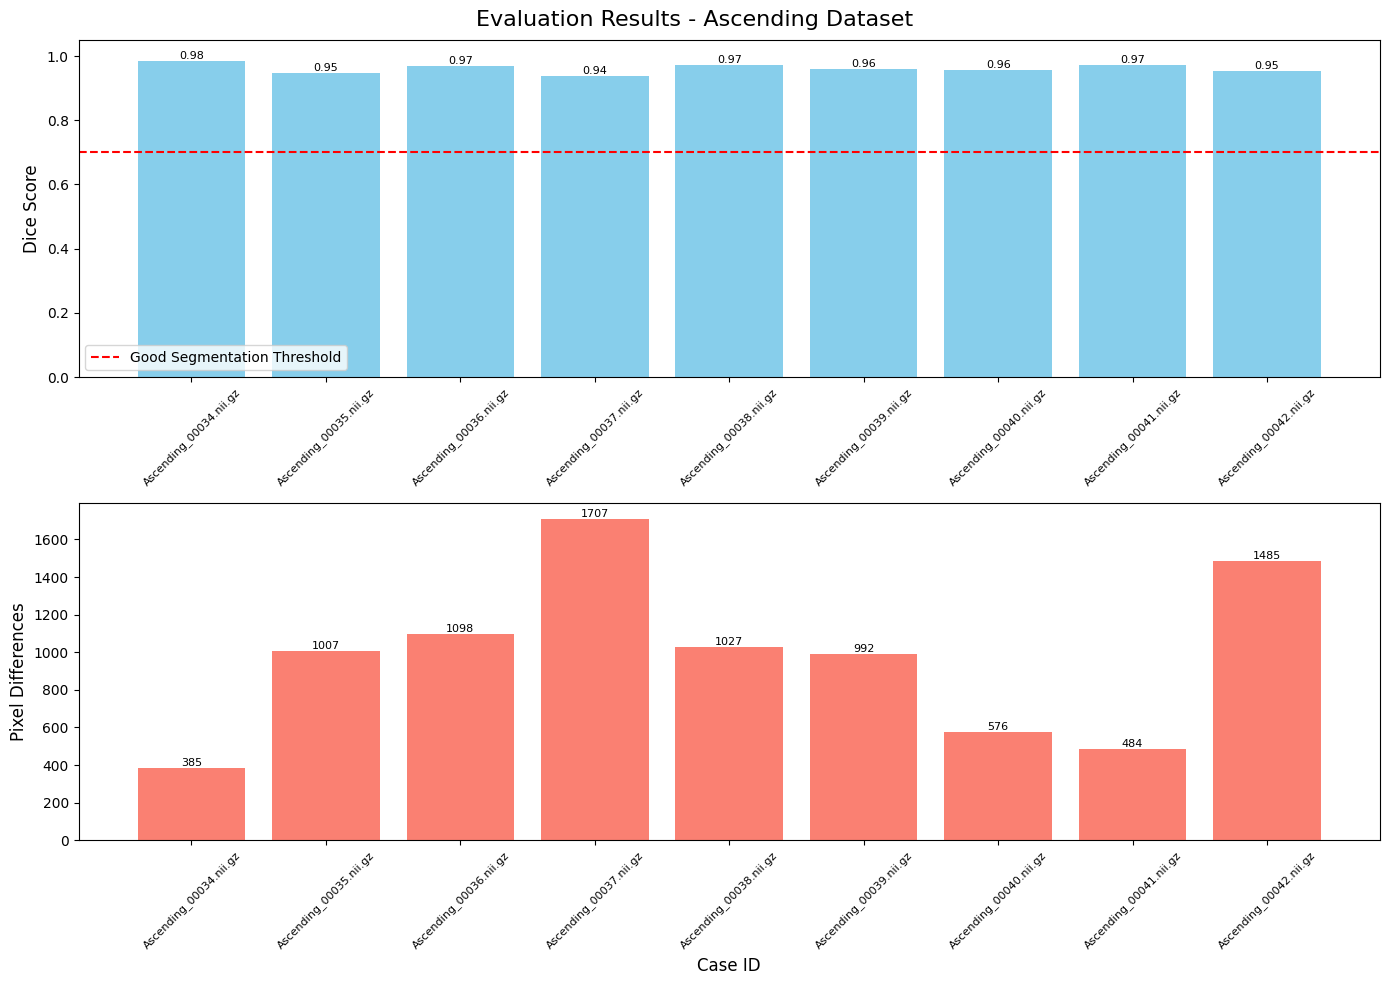

Visualization saved to ../nnUNet_raw/Outputs/Ascending_Ensemble_Outputs/Ascending_evaluation_metrics.png

Summary Statistics:
Mean Dice Score: 0.962 ± 0.014
Median Pixel Differences: 1007
Cases above 0.7 Dice: 9/9


In [17]:
selected_dataset = select_dataset()
evaluation_results = evaluate_predictions(selected_dataset)
save_and_visualize(evaluation_results, selected_dataset)